In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, roc_auc_score

# Load CSV
df = pd.read_csv('URL_data.csv')

# Target variable
y = df['status'].map({'phishing': 1, 'legitimate': 0})  # binary encode target

# Features: separate URL text and numerical columns
url_col = 'url'
num_cols = df.columns.difference(['url', 'status'])

X_urls = df[url_col]
X_numeric = df[num_cols]


In [2]:
# TF-IDF vectorizer for URL text (char ngrams 3-5)
tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5))

# Standard scaler for numerical features
scaler = StandardScaler()

# Combine both
preprocessor = ColumnTransformer(
    transformers=[
        ('url_tfidf', tfidf, url_col),
        ('num', scaler, num_cols)
    ]
)


In [3]:
# Calibrated classifier to get probability outputs
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

base_svc = LinearSVC(C=0.1, random_state=42,max_iter=10000)
svc = CalibratedClassifierCV(estimator=base_svc)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', svc)
])


In [4]:
X = df[[url_col] + list(num_cols)]  # features including URL and numeric
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('url_tfidf',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  ngram_range=(3,
                                                                               5)),
                                                  'url'),
                                                 ('num', StandardScaler(),
                                                  Index(['abnormal_subdomain', 'avg_word_host', 'avg_word_path', 'avg_words_raw',
       'brand_in_path', 'brand_in_subdomain', 'char_repeat', 'dns_record',
       'domain_age', 'domain_in_brand', 'domain_in_title'...
       'ratio_intRedirection', 'ratio_nullHyperlinks', 'right_clic',
       'safe_anchor', 'sfh', 'shortening_service', 'shortest_word_host',
       'shortest_word_path', 'shortest_words_raw', 'statistical_report',
       'submit_email', 'suspecious_tld', 'tld_in_path', 'tld_in_subdomain',
       'web_traffic', 'whois_registered_domain'],
      dtype='object'))])),
                ('classifier',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            max_iter=10000,
                                                            random_state=42)))])

In [5]:
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]  # phishing probability

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1143
           1       0.96      0.96      0.96      1143

    accuracy                           0.96      2286
   macro avg       0.96      0.96      0.96      2286
weighted avg       0.96      0.96      0.96      2286

ROC AUC: 0.9892188673266235


In [6]:
from sklearn.metrics import classification_report, roc_auc_score

# After training your pipeline:

# Predict on training data
y_train_pred = pipeline.predict(X_train)
y_train_proba = pipeline.predict_proba(X_train)[:, 1]

print("Training Metrics:")
print(classification_report(y_train, y_train_pred))
print("Training ROC AUC:", roc_auc_score(y_train, y_train_proba))

# Predict on test data
y_test_pred = pipeline.predict(X_test)
y_test_proba = pipeline.predict_proba(X_test)[:, 1]

print("Test Metrics:")
print(classification_report(y_test, y_test_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_test_proba))


Training Metrics:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4572
           1       0.97      0.97      0.97      4572

    accuracy                           0.97      9144
   macro avg       0.97      0.97      0.97      9144
weighted avg       0.97      0.97      0.97      9144

Training ROC AUC: 0.995779829522622
Test Metrics:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1143
           1       0.96      0.96      0.96      1143

    accuracy                           0.96      2286
   macro avg       0.96      0.96      0.96      2286
weighted avg       0.96      0.96      0.96      2286

Test ROC AUC: 0.9892188673266235


Cross-validation accuracy scores: [0.95538058 0.95975503 0.95450569 0.95625547 0.9623797 ]
Mean CV accuracy: 0.957655293088364


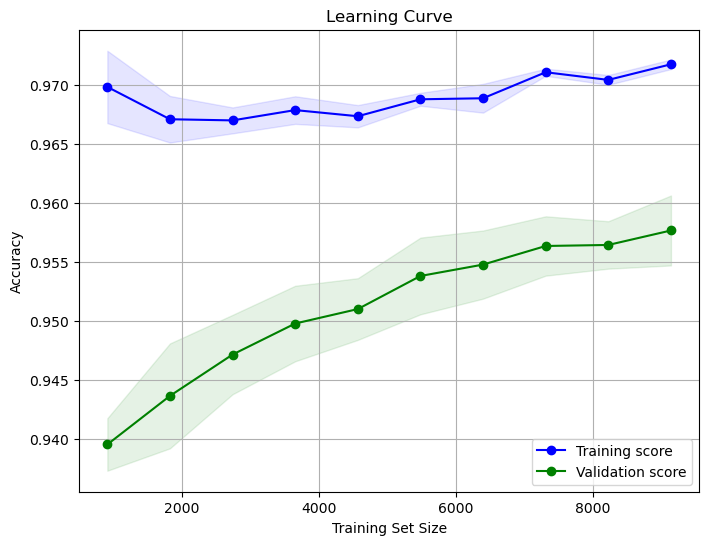

In [7]:
from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your pipeline defined as `pipeline`
# and your full dataset is X and y

# Cross-validation scores (5-fold by default)
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print("Cross-validation accuracy scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

# Learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    pipeline, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and std for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, valid_mean, 'o-', color='green', label='Validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.1, color='green')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()
